In [ ]:
import torch
x = torch.randn(2048, 2048, device='cuda')
y = torch.randn(2048, 2048, device='cuda')

try:
    with torch.no_grad():
        while True:               
            z = x @ y
except KeyboardInterrupt:
    pass
finally:
    del x, y, z
    torch.cuda.empty_cache()  

In [ ]:
# 1) Go to the repo
ROOT=/sfs/gpfs/tardis/home/fph5ms/Nima/PaDIS-MRI-main
cd "$ROOT"

# 2) Use the SAME python as your Jupyter kernel
PY=/home/fph5ms/.conda/envs/myenv/bin/python

# 3) (Optional but safe) BART env vars
export BART_TOOLBOX=/home/fph5ms/bart
export TOOLBOX_PATH=$BART_TOOLBOX
export PATH=$BART_TOOLBOX:$PATH
export PYTHONPATH=$BART_TOOLBOX/python:$PYTHONPATH

# 4) Data + checkpoint + save dir
VAL_DIR=/sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep_rec_data_246x384/val_t2/32dB
CKPT=/sfs/ceph/standard/CBIG-Standard-ECE/Nima/PaDIS-MRI-main/runs/cardiac_h246_w384_rec_pad/32dB/00000-aapm_3-uncond-ddpmpp-pedm-gpus1-batch4-fp32/network-snapshot-011815.pkl
SAVE_ROOT=/sfs/gpfs/tardis/home/fph5ms/Nima/PaDIS-MRI-main/results/padismri_card_d200/card_myTrain011815_10slices_R4_rec_image_rec_pad
mkdir -p "$SAVE_ROOT"

# 5) Run PaDIS evaluation (reconstruction)
CUDA_VISIBLE_DEVICES=0 $PY eval/run.py \
  --algo padis \
  --model_path "$CKPT" \
  --val_dir "$VAL_DIR" \
  --image_size 246 384 \
  --mask_select 4 \
  --pad_y 10 \
  --pad_x 64 \
  --psize 64 \
  --val_count 10 \
  --zeta 3.0 \
  --steps 104 \
  --save_dir "$SAVE_ROOT" \
  --run_evaluate \
  --gpus 0

In [ ]:
ROOT=/sfs/gpfs/tardis/home/fph5ms/Nima/PaDIS-MRI-main
cd "$ROOT"

PY=/home/fph5ms/.conda/envs/myenv/bin/python

# quick sanity checks
$PY -c "import torch; print('torch', torch.__version__, 'cuda', torch.cuda.is_available()); print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'no gpu')"

ls -ld /sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep_h246_w384/cardiac_train_h246_w384_s207/32dB

export WANDB_MODE=disabled

CUDA_VISIBLE_DEVICES=0 $PY -m torch.distributed.run --standalone --nproc_per_node=1 \
  train/padis-mri/train.py \
  --outdir /sfs/ceph/standard/CBIG-Standard-ECE/Nima/PaDIS-MRI-main/runs/cardiac_h246_w384_rec_pad/32dB \
  --data   /sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep_h246_w384/cardiac_train_h246_w384_s207/32dB \
  --cond=0 --arch=ddpmpp --batch=4 --lr=1e-4 --dropout=0.05 \
  --augment=0 --real_p=0.5 --padding=1 --tick=1 --snap=50 --seed=2025 \
  --pad_y=10 --pad_x=64 \
  --patch-list=16,32,64 --patch-probs=0.2,0.3,0.5

In [ ]:
ROOT=/sfs/gpfs/tardis/home/fph5ms/Nima/PaDIS-MRI-main
cd "$ROOT"

PY=/home/fph5ms/.conda/envs/myenv/bin/python

# quick sanity checks
$PY -c "import torch; print('torch', torch.__version__, 'cuda', torch.cuda.is_available()); print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else '')"

ls -ld /sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep_h246_w384/cardiac_train_h246_w384_s207/32dB

export WANDB_MODE=disabled

CUDA_VISIBLE_DEVICES=0 $PY -m torch.distributed.run --standalone --nproc_per_node=1 \
  train/padis-mri/train.py \
  --outdir /sfs/ceph/standard/CBIG-Standard-ECE/Nima/PaDIS-MRI-main/runs/cardiac_h246_w384/32dB \
  --data   /sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep_h246_w384/cardiac_train_h246_w384_s207/32dB \
  --cond=0 --arch=ddpmpp --batch=4 --lr=1e-4 --dropout=0.05 \
  --augment=0 --real_p=0.5 --padding=1 --tick=1 --snap=50 --seed=2025 \
  --pad_width=96 --patch-list=16,32,64 --patch-probs=0.2,0.3,0.5

In [ ]:
# Paths
ROOT=/sfs/gpfs/tardis/home/fph5ms/Nima/PaDIS-MRI-main
PY=/home/fph5ms/.conda/envs/myenv/bin/python

# Cardiac FullSample root (has P*/cine_sax.mat)
TRAIN_H5=/sfs/ceph/standard/CBIG-Standard-ECE/CMR23/MICCAIChallenge2023/ChallengeData/MultiCoil/Cine/TrainingSet/FullSample

# NEW output folder (rect crop-only: 246x384)
OUT=/sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep_h246_w384/

# BART wrapper visibility
export BART_TOOLBOX=/home/fph5ms/bart
export TOOLBOX_PATH=$BART_TOOLBOX
export PATH=$BART_TOOLBOX:$PATH
export PYTHONPATH=$BART_TOOLBOX/python:$PYTHONPATH

mkdir -p "$OUT"
cd "$ROOT"

$PY data/cardiac2D_train_data.py \
  --h5_folder "$TRAIN_H5" \
  --num_slices 3 \
  --output_root "$OUT" \
  --max_volumes 200 \
  --time_index 0 \
  --noise_level 32dB \
  --nproc 30

In [ ]:
# 1) Go to the repo
ROOT=/sfs/gpfs/tardis/home/fph5ms/Nima/PaDIS-MRI-main
cd "$ROOT"

# 2) Use the SAME python as your Jupyter kernel
PY=/home/fph5ms/.conda/envs/myenv/bin/python

# 3) (Optional but safe) BART env vars
export BART_TOOLBOX=/home/fph5ms/bart
export TOOLBOX_PATH=$BART_TOOLBOX
export PATH=$BART_TOOLBOX:$PATH
export PYTHONPATH=$BART_TOOLBOX/python:$PYTHONPATH

# 4) Data + checkpoint + save dir
VAL_DIR=/sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep_rec_data/val_t2/32dB
CKPT=/sfs/ceph/standard/CBIG-Standard-ECE/Nima/PaDIS-MRI-main/runs/cardiac_h246_w384/32dB/00003-aapm_3-uncond-ddpmpp-pedm-gpus1-batch4-fp32/network-snapshot-007840.pkl
SAVE_ROOT=/sfs/gpfs/tardis/home/fph5ms/Nima/PaDIS-MRI-main/results/padismri_card_d200_h246_w384/card_myTrain007840_10slices_R4_rec
mkdir -p "$SAVE_ROOT"

# 5) Run PaDIS evaluation (reconstruction)
CUDA_VISIBLE_DEVICES=0 $PY eval/run.py \
  --algo padis \
  --model_path "$CKPT" \
  --val_dir "$VAL_DIR" \
  --image_size 246 384 \
  --mask_select 4 \
  --pad 96 \
  --psize 64 \
  --val_count 10 \
  --zeta 3.0 \
  --steps 104 \
  --save_dir "$SAVE_ROOT" \
  --run_evaluate \
  --gpus 0


In [ ]:
ROOT=/sfs/gpfs/tardis/home/fph5ms/Nima/PaDIS-MRI-main
PY=/home/fph5ms/.conda/envs/myenv/bin/python

VAL_H5=/sfs/ceph/standard/CBIG-Standard-ECE/CMR23/ChallengeData_test/MultiCoil/Cine/TestSet/FullSample
OUT=/sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep_rec_data_246x384

export BART_TOOLBOX=/home/fph5ms/bart
export TOOLBOX_PATH=$BART_TOOLBOX
export PATH=$BART_TOOLBOX:$PATH
export PYTHONPATH=$BART_TOOLBOX/python:$PYTHONPATH

mkdir -p "$OUT"
cd "$ROOT"

$PY data/cardiac_val_data.py \
  --h5_folder "$VAL_H5" \
  --output_root "$OUT" \
  --noise_level 32dB \
  --acs_size 20 \
  --contrast t2


In [ ]:
# 1) Go to the repo
ROOT=/sfs/gpfs/tardis/home/fph5ms/Nima/PaDIS-MRI-main
cd "$ROOT"

# 2) Use the SAME python as your Jupyter kernel
PY=/home/fph5ms/.conda/envs/myenv/bin/python

# 3) (Optional but safe) BART env vars
export BART_TOOLBOX=/home/fph5ms/bart
export TOOLBOX_PATH=$BART_TOOLBOX
export PATH=$BART_TOOLBOX:$PATH
export PYTHONPATH=$BART_TOOLBOX/python:$PYTHONPATH

# 4) Data + checkpoint + save dir
VAL_DIR=/sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep/val_t2/32dB
CKPT=/sfs/ceph/standard/CBIG-Standard-ECE/Nima/PaDIS-MRI-main/runs/cardiac/32dB/00000-aapm_3-uncond-ddpmpp-pedm-gpus1-batch4-fp32/network-snapshot-029675.pkl
SAVE_ROOT=/sfs/gpfs/tardis/home/fph5ms/Nima/PaDIS-MRI-main/results/padismri_card_d200/card_myTrain029675_10slices_R4_v3
mkdir -p "$SAVE_ROOT"

# 5) Run PaDIS evaluation (reconstruction)
CUDA_VISIBLE_DEVICES=0 $PY eval/run.py \
  --algo padis \
  --model_path "$CKPT" \
  --val_dir "$VAL_DIR" \
  --image_size 384 \
  --pad 96 \
  --psize 64 \
  --val_count 10 \
  --zeta 3.0 \
  --steps 104 \
  --save_dir "$SAVE_ROOT" \
  --run_evaluate \
  --gpus 0


In [ ]:
ROOT=/sfs/gpfs/tardis/home/fph5ms/Nima/PaDIS-MRI-main
PY=/home/fph5ms/.conda/envs/myenv/bin/python

VAL_H5=/sfs/ceph/standard/CBIG-Standard-ECE/CMR23/ChallengeData_test/MultiCoil/Cine/TestSet/FullSample
OUT=/sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep

export BART_TOOLBOX=/home/fph5ms/bart
export TOOLBOX_PATH=$BART_TOOLBOX
export PATH=$BART_TOOLBOX:$PATH
export PYTHONPATH=$BART_TOOLBOX/python:$PYTHONPATH

mkdir -p "$OUT"
cd "$ROOT"

$PY data/cardiac_val_data.py \
  --h5_folder "$VAL_H5" \
  --output_root "$OUT" \
  --noise_level 32dB \
  --acs_size 20 \
  --contrast t2


In [ ]:
ROOT=/sfs/gpfs/tardis/home/fph5ms/Nima/PaDIS-MRI-main
PY=/home/fph5ms/.conda/envs/myenv/bin/python

# Cardiac FullSample root (has P*/cine_sax.mat)
TRAIN_H5=/sfs/ceph/standard/CBIG-Standard-ECE/CMR23/MICCAIChallenge2023/ChallengeData/MultiCoil/Cine/TrainingSet/FullSample

OUT=/sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep/

# BART wrapper visibility (same as brain)
export BART_TOOLBOX=/home/fph5ms/bart
export TOOLBOX_PATH=$BART_TOOLBOX
export PATH=$BART_TOOLBOX:$PATH
export PYTHONPATH=$BART_TOOLBOX/python:$PYTHONPATH

mkdir -p "$OUT"
cd "$ROOT"

$PY data/cardiac2D_train_data.py \
  --h5_folder "$TRAIN_H5" \
  --num_slices 3 \
  --output_root "$OUT" \
  --max_volumes 200 \
  --time_index 0 \
  --noise_level 32dB \
  --nproc 30


In [ ]:
ROOT=/sfs/gpfs/tardis/home/fph5ms/Nima/PaDIS-MRI-main
cd "$ROOT"

PY=/home/fph5ms/.conda/envs/myenv/bin/python

# quick sanity checks (keep same style)
$PY -c "import torch; print('torch', torch.__version__, 'cuda', torch.cuda.is_available()); print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else '')"


ls -ld /sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep/cardiac_train_d384_s207/32dB

export WANDB_MODE=disabled

# train (same flags as brain; only outdir + data changed)
CUDA_VISIBLE_DEVICES=0 $PY -m torch.distributed.run --standalone --nproc_per_node=1 \
  train/padis-mri/train.py \
  --outdir /sfs/ceph/standard/CBIG-Standard-ECE/Nima/PaDIS-MRI-main/runs/cardiac/32dB \
  --data /sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep/cardiac_train_d384_s207/32dB \
  --cond=0 --arch=ddpmpp --batch=4 --lr=1e-4 --dropout=0.05 \
  --augment=0 --real_p=0.5 --padding=1 --tick=1 --snap=50 --seed=2025 \
  --pad_width=96 --patch-list=16,32,64 --patch-probs=0.2,0.3,0.5


In [2]:
import glob, torch, numpy as np

VAL_DIR = "/sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep/val_t2/32dB"
pt = sorted(glob.glob(f"{VAL_DIR}/sample_*.pt"))[0]
d = torch.load(pt, map_location="cpu")

print("pt:", pt)
print("keys:", sorted(d.keys()))

# change these two lines if your key names differ
k = d["ksp"]          # expected complex tensor, shape ~ (H,W,coils) or (coils,H,W)
gt = d["gt"]              # expected real tensor, shape (H,W)

k = k.numpy()
gt = gt.numpy()

# make k -> (coils,H,W)
if k.ndim == 3 and k.shape[0] in [8,10,12,16,20]:
    kc = k
else:
    kc = np.moveaxis(k, -1, 0)

# IFFT convention used in your earlier notebook
imgc = np.fft.ifft2(np.fft.ifftshift(kc, axes=(-2,-1)), axes=(-2,-1), norm="ortho")
imgc = np.fft.fftshift(imgc, axes=(-2,-1))
rss = np.sqrt((np.abs(imgc)**2).sum(axis=0))

# compare shapes and correlation
print("gt shape:", gt.shape, "rss shape:", rss.shape)
print("corr(gt,rss):", np.corrcoef(gt.ravel(), rss.ravel())[0,1])
print("rel L2 error:", np.linalg.norm((gt-gt.max()*rss/rss.max()).ravel())/np.linalg.norm(gt.ravel()))


pt: /sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep/val_t2/32dB/sample_0.pt
keys: ['gt', 'ksp', 'mask_10', 'mask_2', 'mask_3', 'mask_4', 'mask_5', 'mask_6', 'mask_7', 'mask_8', 'mask_9', 'norm_consts_99', 's_map']
gt shape: (384, 384) rss shape: (384, 384)
corr(gt,rss): (-0.10936894529075866-0.14931591322607368j)
rel L2 error: 1.3816119356740606


/tmp/ipykernel_467666/1055919198.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(pt, map_location="cpu")


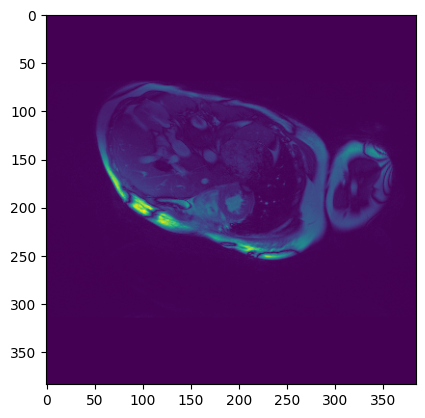

In [3]:
import matplotlib.pyplot as plt

plt.imshow(rss)

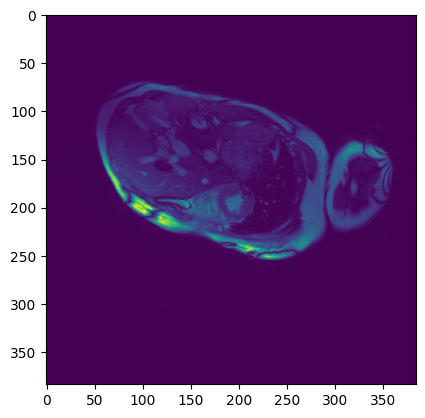

In [5]:
plt.imshow(np.abs(gt))

In [6]:
mask = d["mask_4"]
print(mask.shape)

torch.Size([1, 384, 384])


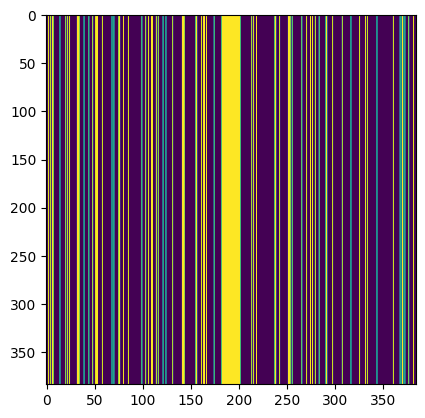

In [7]:
plt.imshow(mask[0])

In [8]:
gt_mag  = np.abs(gt)
rss_mag = np.abs(rss)

# best scalar fit rss -> gt
scale = (gt_mag * rss_mag).sum() / (rss_mag**2).sum()
rel_l2 = np.linalg.norm(gt_mag - scale * rss_mag) / np.linalg.norm(gt_mag)

corr = np.corrcoef(gt_mag.ravel(), (scale * rss_mag).ravel())[0,1]

print("scale:", scale)
print("corr(|gt|, scaled rss):", corr)
print("rel L2 (magnitudes):", rel_l2)


scale: 0.995019213420299
corr(|gt|, scaled rss): 0.9996796505628173
rel L2 (magnitudes): 0.029186535017970403


pt: /sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep/val_t2/32dB/sample_0.pt
s_map shape (coils,H,W): (10, 384, 384)
sos stats inside body:
  mean: 1.0
  median: 1.0
  min/max: 0.9999995827674866 1.0000004768371582


/tmp/ipykernel_467666/3747832762.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(pt, map_location="cpu")


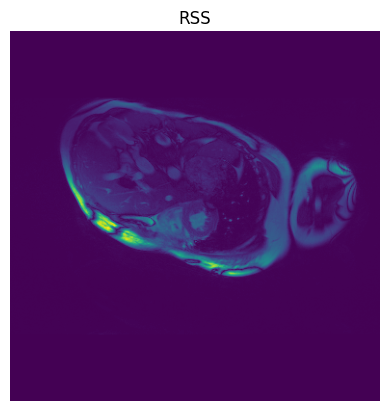

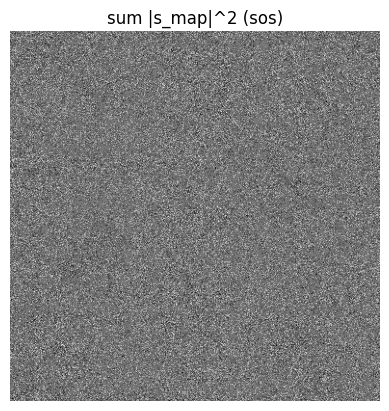

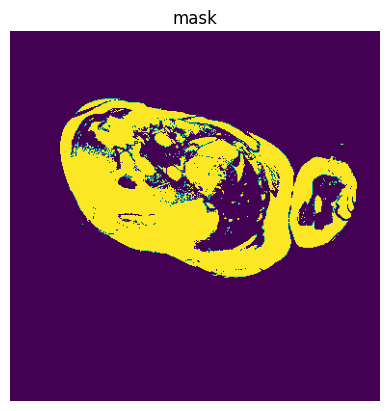

In [10]:
import glob, torch, numpy as np
import matplotlib.pyplot as plt

VAL_DIR = "/sfs/ceph/standard/CBIG-Standard-ECE/Nima/data/cardiac_prep/val_t2/32dB"
pt = sorted(glob.glob(f"{VAL_DIR}/sample_*.pt"))[0]
d = torch.load(pt, map_location="cpu")

s = d["s_map"]   # complex sensitivity maps
k = d["ksp"]

s = s.detach().cpu().numpy()
k = k.detach().cpu().numpy()

# make s -> (coils,H,W)
if s.ndim == 3 and s.shape[0] in [8,10,12,16,20]:
    sc = s
else:
    sc = np.moveaxis(s, -1, 0)

# make k -> (coils,H,W)
if k.ndim == 3 and k.shape[0] in [8,10,12,16,20]:
    kc = k
else:
    kc = np.moveaxis(k, -1, 0)

# RSS image from ksp (for a body mask)
imgc = np.fft.ifft2(np.fft.ifftshift(kc, axes=(-2,-1)), axes=(-2,-1), norm="ortho")
imgc = np.fft.fftshift(imgc, axes=(-2,-1))
rss = np.sqrt((np.abs(imgc)**2).sum(axis=0))

# sum |s_map|^2
sos = (np.abs(sc)**2).sum(axis=0)

# body mask (adjust threshold if needed)
mask = rss > (0.05 * rss.max())

vals = sos[mask]
print("pt:", pt)
print("s_map shape (coils,H,W):", sc.shape)
print("sos stats inside body:")
print("  mean:", float(vals.mean()))
print("  median:", float(np.median(vals)))
print("  min/max:", float(vals.min()), float(vals.max()))

plt.figure(); plt.title("RSS"); plt.imshow(rss); plt.axis("off")
plt.figure(); plt.title("sum |s_map|^2 (sos)"); plt.imshow(sos,cmap="gray"); plt.axis("off")
plt.figure(); plt.title("mask"); plt.imshow(mask); plt.axis("off")
plt.show()


In [11]:
print("  min/max:", float(sos.min()), float(sos.max()))


  min/max: 0.9999995827674866 1.0000004768371582
